### Import required libraries

In [1]:
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import linear_model
from sklearn.metrics import r2_score
from scipy.stats import skewnorm
from scipy.optimize import minimize

### Create user functions

In [2]:
# ------------------------------
def f_logistic(x, logistic_params):
    
    """Applies logistic function to an input
    
    Input:
        "x": input data (array/dataframe)
        "logistic_params": [M, k, X0] parameters (list)
        
    Output:
        "fx": f-logistic(x) (array/dataframe)
    """
    
    [M, k, X0] = logistic_params
    fx = M / (1 + np.exp(- k *(x - X0)))
    
    return (fx)


# ------------------------------
def f_skewnorm(x, skew_params):
    
    """Applies skew-norm function to an input
    
    Input:
        "x": input data (array/dataframe)
        "skew_params": [A, shape, loc, scale] parameters (list)
        
    Output:
        "skew_norm": f-skew-norm(x) (array/dataframe)
    """
    
    [A, shape, loc, scale] = skew_params
    skew_norm = A * skewnorm.pdf(x, shape, loc, scale)
    
    return (skew_norm)


# ------------------------------
def objective(fit_parameters):
    
    """Objective function to calculate mathematical-model-fit (1 - R2_value) based on
    any given set of logistic and skew parameters
    
    Input:
        "fit_parameters": [M, k, X0, A, shape, loc, scale] parameters (list)
    
    Output:
        "R2_f": objective parameter to be minimized (1 - R2_value)
    """
    
    [M, k, X0, A, shape, loc, scale] = fit_parameters
    logistic_params = [M, k, X0]
    skew_params = [A, shape, loc, scale]
    
    f_logistic_VEC = f_logistic(feats_fit["VEC"], logistic_params)
    P_phase_residuals = P_phase_NN_fit - f_logistic_VEC
    f_VEC_skew = f_skewnorm(feats_fit["VEC"], skew_params)
        
    #feat_names_without_VEC = feat_names.remove("VEC")
    feats_norm_scaled = feats_fit_norm[feat_names_without_VEC].mul(f_VEC_skew, axis = 0)
    
    X = feats_norm_scaled
    Y = P_phase_residuals
    
    global mod_lin
    mod_lin = linear_model.LinearRegression()
    mod_lin.fit(X, Y)
    P_phase_residuals_lin_fit = mod_lin.predict(X)
    
    global P_phase_RM_fit
    P_phase_RM_fit = f_logistic_VEC + P_phase_residuals_lin_fit
    
    global mae_P_phase, mse_P_phase, R2_P_phase
    mae_P_phase = np.mean(np.abs(P_phase_NN_fit - P_phase_RM_fit))
    mse_P_phase = np.mean((P_phase_NN_fit - P_phase_RM_fit) ** 2)
    R2_P_phase = r2_score(P_phase_NN_fit, P_phase_RM_fit)
    R2_f = 1 - R2_P_phase
    
    return (R2_f)


# ------------------------------
def f_RM_mod_predict(x, x_norm, logistic_params, skew_params, bias, coeff):
    
    """Reduced mathematical model function to calculate P(phase) values predicted by RM model.
    
    Input:
        "x": features (dataframe)
        "x_norm": normalized features (dataframe)
        "logistic_params": [M, k, X0] parameters (list)
        "skew_params": [A, shape, loc, scale] parameters (list)
        "bias": bias parameter value (float)
        "coeff": linear fit coefficients (array)
    
    Output:
        "P_phase_RM": P(phase) values predicted by RM model (array)
        "df_feat_contri": Feature contributions toward P_phase_RM calculation (dataframe)
    """
    
    f_logistic_VEC = f_logistic(x["VEC"], logistic_params)
    f_skew_VEC = f_skewnorm(x["VEC"], skew_params)
    
    #feat_names_without_VEC = feat_names.remove("VEC")
    feats_norm_scaled = x_norm[feat_names_without_VEC].mul(f_skew_VEC, axis = 0)
    P_phase_RM = (np.array(f_logistic_VEC).reshape(len(f_logistic_VEC), 1) +
                  bias + np.matmul(np.array(feats_norm_scaled), coeff))
    
    df_feat_contri = pd.DataFrame()
    count = 0
    for feat in (["VEC"] + feat_names_without_VEC):
        if feat == "VEC":
            df_feat_contri["c_" + feat] = f_logistic_VEC
        else:
            df_feat_contri["c_" + feat] = np.array(feats_norm_scaled[feat]) * coeff[count]
            count += 1
        
    return (P_phase_RM, df_feat_contri)


# ------------------------------
def f_class_accuracy(P_phase_NN, P_phase_RM):
    
    """Calculates class accuracy for phase prediction
    
    Input:
        "P_phase_NN": P_phase from neural network model
        "P_phase_RM": P_phase from RM model
    
    Output:
        "class_acc_percent": Phase classification accuracy percentage (float)
        "class_error_list": class error list (list)
    """
    
    class_error_list = []
    for i in range(0, P_phase_NN.shape[0]):

        if ((P_phase_NN[i] >= 0.5 and P_phase_RM[i] < 0.5) or
            (P_phase_NN[i] < 0.5 and P_phase_RM[i] >= 0.5)):

            class_error_list.append(1)

        else:
            class_error_list.append(0)

    wrong_count = (np.array(class_error_list) == 1).sum()
    class_acc_percent = round(100 * (P_phase_NN.shape[0] - wrong_count)/P_phase_NN.shape[0],3)
    
    return (class_acc_percent, class_error_list)

### Input the phase name ("FCC" or "BCC") being modelled here

In [3]:
phase_name = "FCC"

### Load fitting and validation dataset generated from ML (neural network) model

In [4]:
# Fitting dataset (comprises HEAs with 5,6 and 7 elements)
db_fit = pd.read_excel("_database\\df-hea-fit.xlsx") # absolute features
db_fit_norm = pd.read_excel("_database\\df-hea-fit-normFeats.xlsx") # normalized features

# Validation dataset (comprises HEAs with 8 and 9 elements)
db_val = pd.read_excel("_database\\df-hea-val.xlsx") # absolute features
db_val_norm = pd.read_excel("_database\\df-hea-val-normFeats.xlsx") # normalized features

### Extract phase occurence probabilities predicted by neural network (NN) model

In [5]:
P_phase_NN_fit = db_fit[f"P({phase_name})"] # fitting dataset
P_phase_NN_val = db_val[f"P({phase_name})"] # validation dataset

### Extract absolute and normalized feature values from dataset

In [6]:
feat_names = ["R_delta","VEC","R_cov_delta","E_delta","E_coh","H_ch","H_el"]
feat_names_without_VEC = ["R_delta","R_cov_delta","E_delta","E_coh","H_ch","H_el"]

feats_fit = db_fit[feat_names] # feature values
feats_fit_norm = db_fit_norm[feat_names] # normalized feature values

feats_val = db_val[feat_names] # feature for validation dataset
feats_val_norm = db_val_norm[feat_names] # normalized features for validation dataset

### Visualize dependence of occurence probability of P(phase) on VEC

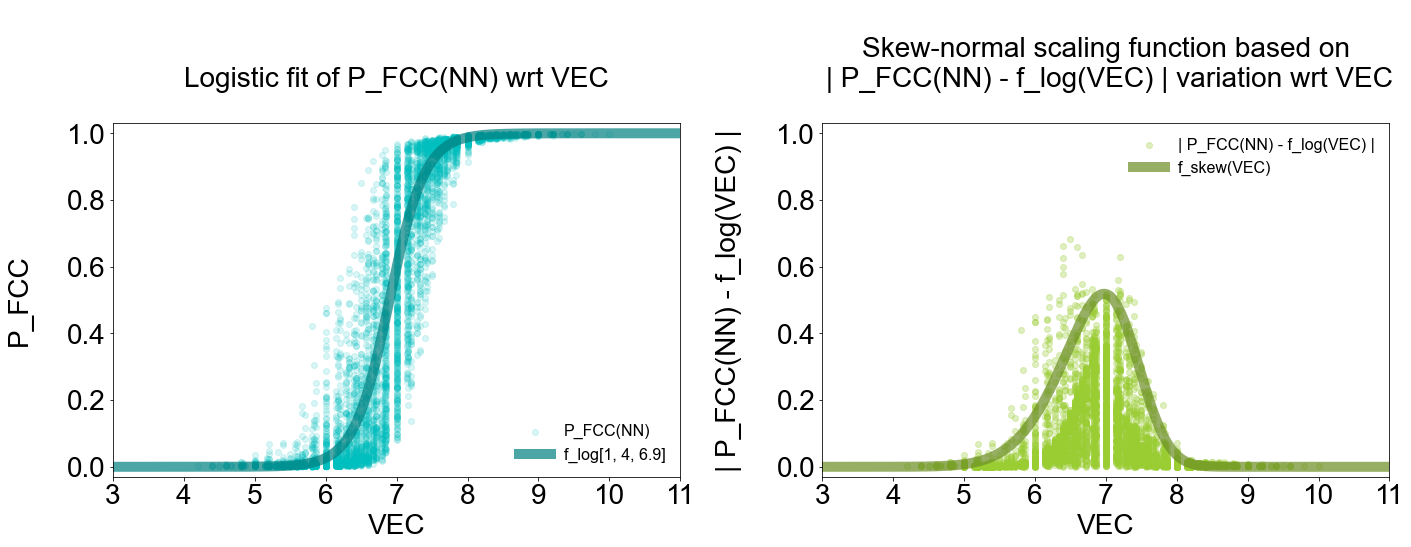

In [7]:
logistic_params = [1, 4, 6.9]
skew_params = [0.7, - 2, 7.4, 0.8]
f_logistic_VEC = f_logistic(feats_fit["VEC"], logistic_params)
P_phase_residuals = P_phase_NN_fit - f_logistic_VEC

# ------------------------------
# Defining parameters for plotting
font = {'family' : 'Arial',
        'weight' : 'regular',
        'size'   : 20}

matplotlib.rc('font', **font)

fig_size = (20,8)
fs = 28 #fontsize
symb_size = 60
line_width = 10
# ------------------------------


plt.figure(figsize=fig_size)

# ------------------------------
plt.subplot(1, 2, 1) # Plot for logistic fit
plt.title(f"Logistic fit of P_{phase_name}(NN) wrt VEC\n", fontsize=fs)
plt.scatter(feats_fit["VEC"], P_phase_NN_fit, color="c", alpha=0.15, label=f"P_{phase_name}(NN)") # Plot P(phase) vs. VEC for fitting dataset

# Plot f_logistic fit of VEC based on 'logistic_params'
x_VEC = np.linspace(3, 11, 200)
f_logistic_x_VEC = f_logistic(x_VEC, logistic_params)
plt.plot(x_VEC, f_logistic_x_VEC, c="teal", lw=line_width, alpha=0.7, label=f"f_log{str(logistic_params)}")
plt.xlim(3,11); plt.ylim(- 0.03, 1.03)
plt.xticks(fontsize=fs); plt.yticks(fontsize=fs)
plt.xlabel("VEC", fontsize=fs); plt.ylabel(f"P_{phase_name}\n", fontsize=fs)
plt.legend(loc="lower right", fontsize=fs-12, frameon=False)

# ------------------------------
plt.subplot(1, 2, 2) # Plot for residuals and peak-residual fit (skew-norm)
plt.title(f"\nSkew-normal scaling function based on\n | P_{phase_name}(NN) - f_log(VEC) | variation wrt VEC\n", fontsize=fs)
plt.scatter(feats_fit["VEC"], np.abs(P_phase_residuals), c="yellowgreen", alpha=0.3, label=f"| P_{phase_name}(NN) - f_log(VEC) |") # Plot residuals

# Plot skew-norm fit of peak residuals based on 'skew_params'
y_VEC_skew = f_skewnorm(x_VEC, skew_params)
plt.plot(x_VEC, y_VEC_skew, c="olivedrab", lw=line_width, alpha=0.7, label="f_skew(VEC)")
plt.xlim(3,11); plt.ylim(- 0.03, 1.03)
plt.xticks(fontsize=fs); plt.yticks(fontsize=fs)
plt.xlabel("VEC", fontsize=fs); plt.ylabel(f"| P_{phase_name}(NN) - f_log(VEC) |\n", fontsize=fs)
plt.legend(loc="upper right", fontsize=fs-12, frameon=False)
# ------------------------------

plt.tight_layout()
plt.show()

## **Optimize Reduced Mathematical Model**

In [8]:
# Order of fit parameters - [M, k, X0, A, shape, loc, scale]

solver = "L-BFGS-B"
init_guess = [1, 2.5, 6.5, 1, -2, 7.3, 0.7] # initial guess

# Create individual bounds for each fit parameter
b_M = (1, 1.1)
b_k = (2, 4)
b_X0 = (5, 8)
b_A = (0.5, 2)
b_shape = (-4, 2)
b_loc = (5, 8)
b_scale = (0.1,2)

bnds = (b_M, b_k, b_X0, b_A, b_shape, b_loc, b_scale)

print(f"Optimizing the Reduced Mathematical (RM) model for P({phase_name})...", end="")
sol = minimize(objective, init_guess, method=solver, bounds=bnds)
print("DONE.")

print(f"RM_mod (Performance on Fiting Dataset): mae={round(mae_P_phase,4)}, R2={round(R2_P_phase, 3)}")

Optimizing the Reduced Mathematical (RM) model for P(FCC)...DONE.
RM_mod (Performance on Fiting Dataset): mae=0.0512, R2=0.964


### Extract final parameters from optimized model

In [9]:
# Store optimized model parameters
RM_mod_logistic_params = sol.x[0:3]
RM_mod_skew_params = sol.x[3:]

RM_mod_coeff= mod_lin.coef_.reshape(6,1)
RM_mod_bias = mod_lin.intercept_

RM_mod_perf_fit = {"mae":mae_P_phase, "R2":R2_P_phase}

print("RM_mod (Logistic parameters):", list(np.around(RM_mod_logistic_params, 3)))
print("RM_mod (Skew-norm parameters):", list(np.around(RM_mod_skew_params, 2)))
print(f"RM_mod (Linear fit parameters): Bias={round(RM_mod_bias, 4)}, Coeff=", list(np.around(RM_mod_coeff.reshape(6,), 2)))

RM_mod (Logistic parameters): [1.0, 3.365, 6.624]
RM_mod (Skew-norm parameters): [1.0, -1.26, 7.21, 0.56]
RM_mod (Linear fit parameters): Bias=-0.0033, Coeff= [-1.5, 1.85, 0.85, -3.36, 0.09, 0.53]


### Get RM model prediction, feature contributions and classification accuracy for fitting dataset

In [10]:
P_phase_RM_fit, RM_feat_contri = f_RM_mod_predict(feats_fit, feats_fit_norm, RM_mod_logistic_params,
                                                  RM_mod_skew_params, RM_mod_bias, RM_mod_coeff)

RM_fit_acc, RM_fit_err_list = f_class_accuracy(P_phase_NN_fit, P_phase_RM_fit)

print(f"RM Mod for P({phase_name}): Classification Accuracy = {RM_fit_acc} %")

RM Mod for P(FCC): Classification Accuracy = 97.245 %


### **Plot frequency density plots of feature contributions for fitting dataset**

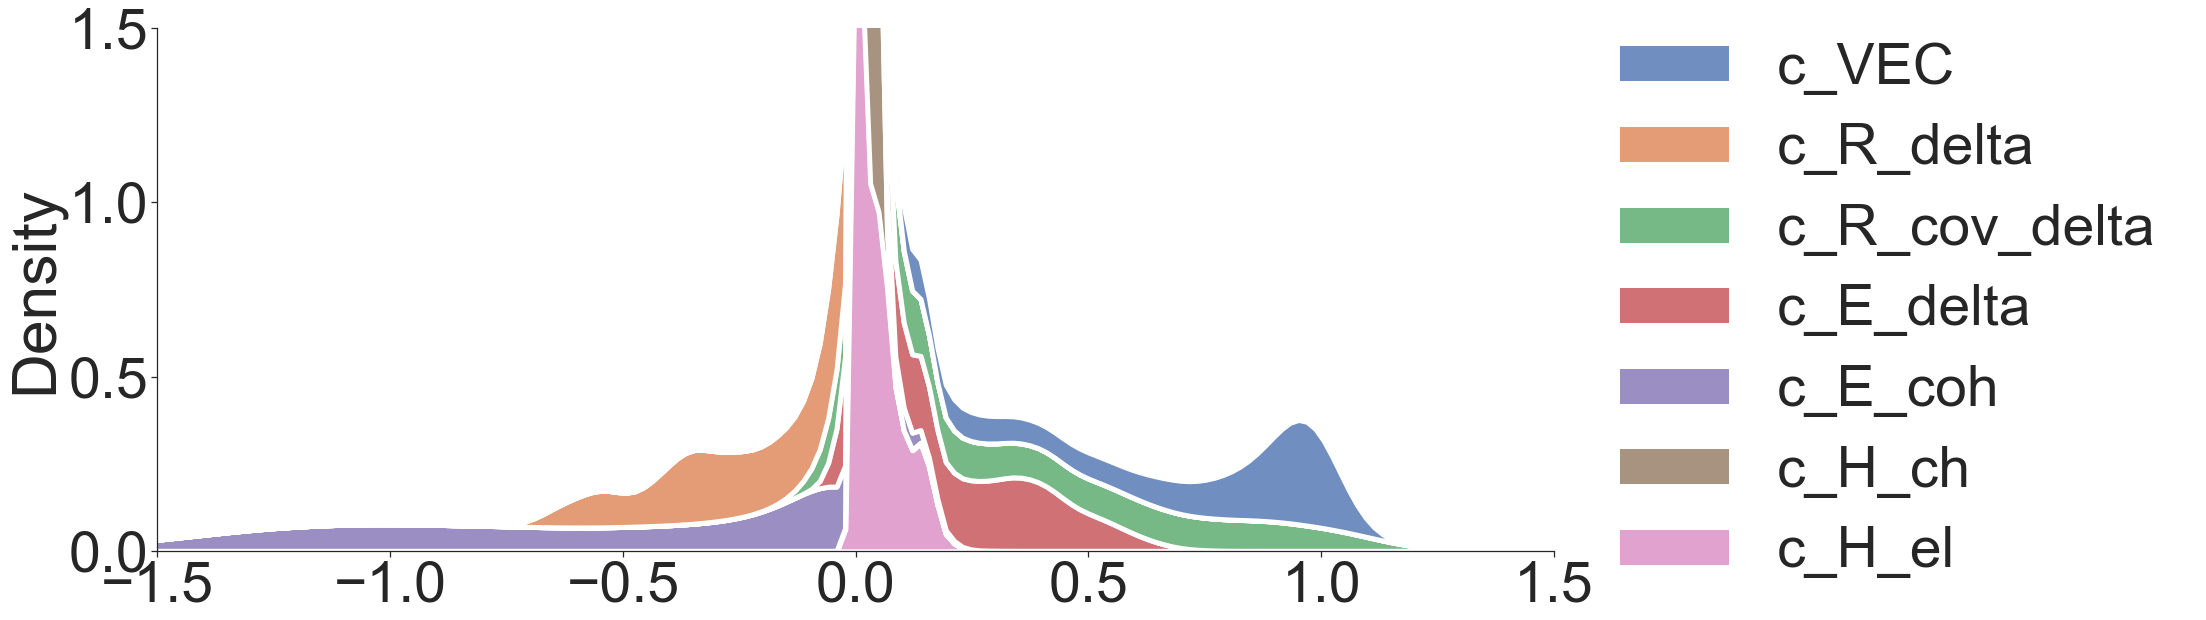

In [11]:
font = {'family' : 'Arial',
        'weight' : 'regular',
        'size'   : 40}

matplotlib.rc('font', **font)

f_cols = ['lime', 'lightcoral', 'darkorange', 'blue', 'cyan', 'red', 'yellowgreen']

fig_height = 10
aspect_ratio = 2.3
fs = 28 #fontsize
symb_size = 60
line_width = 8
alpha = 0.8

sns.set(font_scale = 5.2)
sns.set_style("whitegrid", {'axes.grid' : False})
sns.set_style("ticks")
fig = sns.displot(RM_feat_contri, kind="kde", multiple="stack", height=fig_height,
                  aspect=aspect_ratio, linewidth=line_width-3, alpha=alpha)
fig.set(xlim=(-1.5,1.5), ylim=(0,1.5))

### **Plot P_phase(RM) vs P_phase(NN) parity plot for fitting dataset**

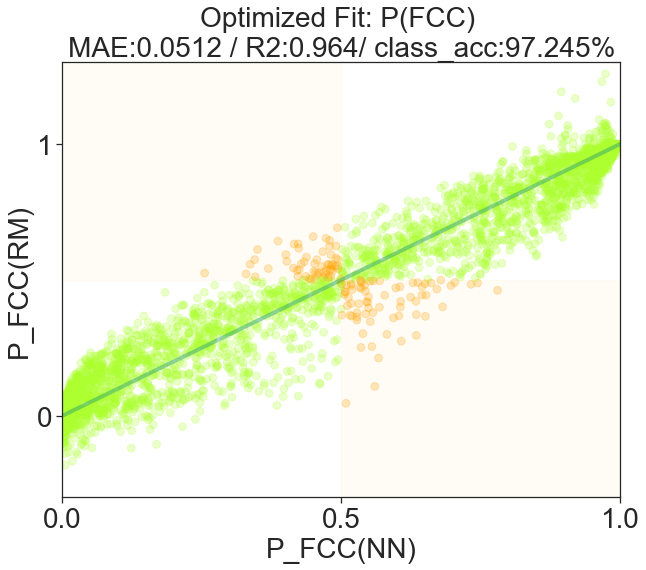

In [12]:
fig_size = (10,8)
fs = 28; #fontsize
symb_size = 60;

plt.figure(figsize=fig_size)

plt.title(f"Optimized Fit: P({phase_name}) \nMAE:{round(mae_P_phase,4)} / R2:{round(R2_P_phase,3)}/ class_acc:{RM_fit_acc}%",
         fontsize=fs)

pt_colors = []
for pt_i in range(0, P_phase_NN_fit.shape[0]):
    if RM_fit_err_list[pt_i] == 1: pt_colors.append("orange")
    else: pt_colors.append("greenyellow")

plt.scatter(P_phase_NN_fit, P_phase_RM_fit, s=symb_size, alpha=0.25, c=pt_colors)

plt.plot([0,1], [0,1], c="teal", alpha=0.35, linewidth=4)

plt.xlim(0,1); plt.ylim(-0.3,1.3)
plt.xticks(fontsize=fs); plt.yticks(fontsize=fs)
plt.xlabel(f"P_{phase_name}(NN)", fontsize=fs); plt.ylabel(f"P_{phase_name}(RM)", fontsize=fs)
plt.fill_between([0, 0.5], 0.5, 1.3, color="orange", alpha=0.04)
plt.fill_between([0.5, 1], -0.3, 0.5, color="orange", alpha=0.04)

plt.show()

### **Plot OPTIMIZED logistic function and skew-normal function**

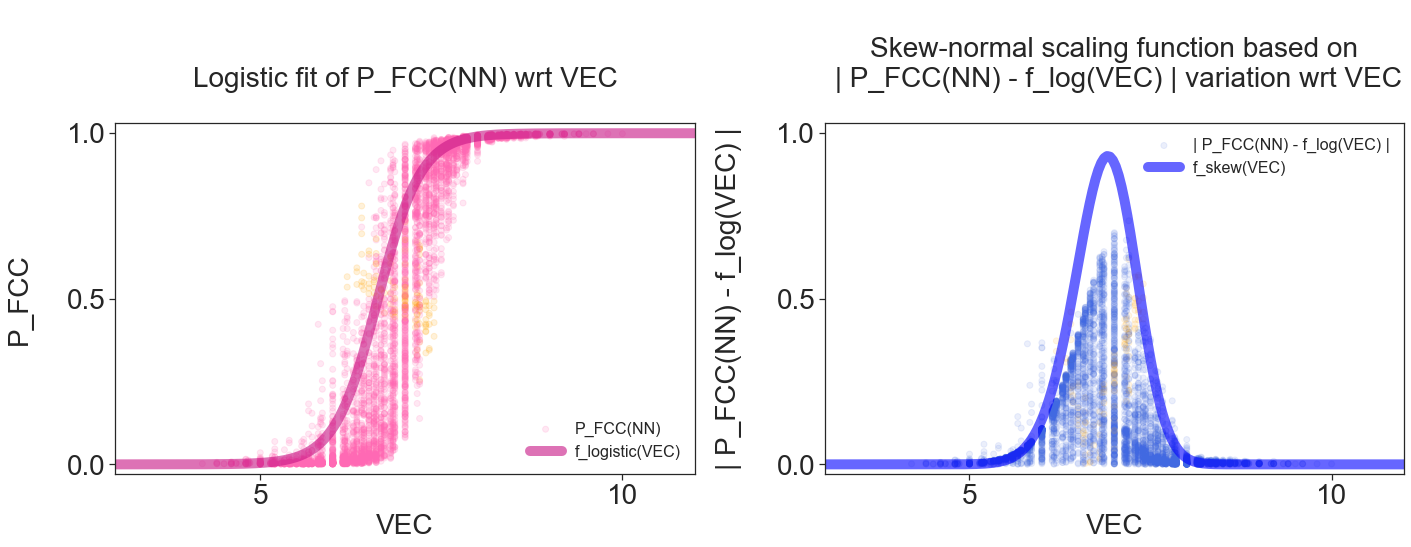

In [13]:
logistic_params = RM_mod_logistic_params
skew_params = RM_mod_skew_params
f_logistic_VEC = f_logistic(feats_fit["VEC"], logistic_params)
P_phase_residuals = P_phase_NN_fit - f_logistic_VEC

# ------------------------------
# Defining parameters for plotting
font = {'family' : 'Arial',
        'weight' : 'regular',
        'size'   : 20}

matplotlib.rc('font', **font)

fig_size = (20,8)
fs = 28 #fontsize
symb_size = 60
line_width = 10
# ------------------------------


plt.figure(figsize=fig_size)

# ------------------------------
# Plot optimized logistic function
pt_colors = []
for pt_i in range(0, P_phase_NN_fit.shape[0]):
    if RM_fit_err_list[pt_i] == 1: pt_colors.append("orange")
    else: pt_colors.append("hotpink")
    
plt.subplot(1, 2, 1) # Plot for logistic fit
plt.title(f"Logistic fit of P_{phase_name}(NN) wrt VEC\n", fontsize=fs)
plt.scatter(feats_fit["VEC"], P_phase_NN_fit, c=pt_colors, alpha=0.15, label=f"P_{phase_name}(NN)") # Plot P(phase) vs. VEC for fitting dataset

# Plot f_logistic fit of VEC based on 'logistic_params'
x_VEC = np.linspace(3, 11, 200)
f_logistic_x_VEC = f_logistic(x_VEC, logistic_params)
plt.plot(x_VEC, f_logistic_x_VEC, c="mediumvioletred", lw=line_width, alpha=0.6, label="f_logistic(VEC)")
plt.xlim(3,11); plt.ylim(- 0.03, 1.03)
plt.xticks(fontsize=fs); plt.yticks(fontsize=fs)
plt.xlabel("VEC", fontsize=fs); plt.ylabel(f"P_{phase_name}\n", fontsize=fs)
plt.legend(loc="lower right", fontsize=fs-12, frameon=False)

# ------------------------------
# Plot optimized skew-normal function
pt_colors = []
for pt_i in range(0, P_phase_NN_fit.shape[0]):
    if RM_fit_err_list[pt_i] == 1: pt_colors.append("orange")
    else: pt_colors.append("royalblue")

plt.subplot(1, 2, 2) # Plot for residuals and peak-residual fit (skew-norm)
plt.title(f"\nSkew-normal scaling function based on\n | P_{phase_name}(NN) - f_log(VEC) | variation wrt VEC\n", fontsize=fs)
plt.scatter(feats_fit["VEC"], np.abs(P_phase_residuals), c=pt_colors, alpha=0.1, label=f"| P_{phase_name}(NN) - f_log(VEC) |") # Plot residuals

# Plot skew-norm fit of peak residuals based on 'skew_params'
y_VEC_skew = f_skewnorm(x_VEC, skew_params)
plt.plot(x_VEC, y_VEC_skew, c="blue", lw=line_width, alpha=0.6, label="f_skew(VEC)")
plt.xlim(3,11); plt.ylim(- 0.03, 1.03)
plt.xticks(fontsize=fs); plt.yticks(fontsize=fs)
plt.xlabel("VEC", fontsize=fs); plt.ylabel(f"| P_{phase_name}(NN) - f_log(VEC) |\n", fontsize=fs)
plt.legend(loc="upper right", fontsize=fs-12, frameon=False)
# ------------------------------

plt.tight_layout()
plt.show()

### **RM Model performance over validation dataset that was not used for fitting**

RM Mod for P(FCC): Classification Accuracy (Validation dataset)= 97.103 %


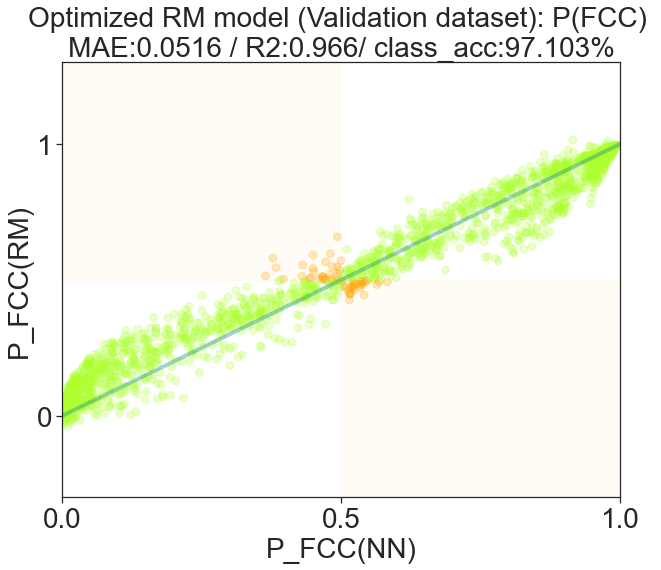

In [14]:
P_phase_RM_val, _ = f_RM_mod_predict(feats_val, feats_val_norm, RM_mod_logistic_params,
                                                  RM_mod_skew_params, RM_mod_bias, RM_mod_coeff)

P_phase_RM_val = P_phase_RM_val.reshape((P_phase_RM_val.shape[0],))
mae_P_phase_val = np.mean(np.abs(P_phase_NN_val - P_phase_RM_val))
mse_P_phase_val = np.mean((P_phase_NN_val - P_phase_RM_val) ** 2)
R2_P_phase_val = r2_score(P_phase_NN_val, P_phase_RM_val)
    
RM_val_acc, RM_val_err_list = f_class_accuracy(P_phase_NN_val, P_phase_RM_val)

print(f"RM Mod for P({phase_name}): Classification Accuracy (Validation dataset)= {RM_val_acc} %")

# ------------------------------
# Parity plot of P_phase(RM) vs P_phase(NN) for validation dataset
fig_size = (10,8)
fs = 28; #fontsize
symb_size = 60;

plt.figure(figsize=fig_size)

plt.title(f"Optimized RM model (Validation dataset): P({phase_name}) \nMAE:{round(mae_P_phase_val,4)} / R2:{round(R2_P_phase_val,3)}/ class_acc:{RM_val_acc}%",
         fontsize=fs)

pt_colors = []
for pt_i in range(0, P_phase_NN_val.shape[0]):
    if RM_val_err_list[pt_i] == 1: pt_colors.append("orange")
    else: pt_colors.append("greenyellow")

plt.scatter(P_phase_NN_val, P_phase_RM_val, s=symb_size, alpha=0.25, c=pt_colors)

plt.plot([0,1], [0,1], c="teal", alpha=0.35, linewidth=4)

plt.xlim(0,1); plt.ylim(-0.3,1.3)
plt.xticks(fontsize=fs); plt.yticks(fontsize=fs)
plt.xlabel(f"P_{phase_name}(NN)", fontsize=fs); plt.ylabel(f"P_{phase_name}(RM)", fontsize=fs)
plt.fill_between([0, 0.5], 0.5, 1.3, color="orange", alpha=0.04)
plt.fill_between([0.5, 1], -0.3, 0.5, color="orange", alpha=0.04)

plt.show()